<a href="https://colab.research.google.com/github/MJ199999/WaterPotability/blob/main/WaterQuality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dataprep

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
data = pd.read_csv("water_potability.csv")

In [ ]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


DataPrep Report
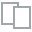
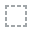
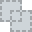
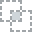
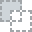
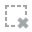
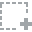
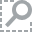
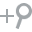
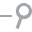
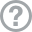
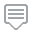
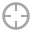
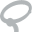
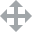
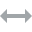
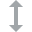
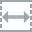
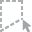
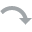
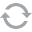
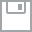
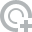
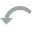
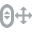
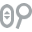
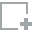
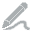
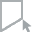
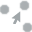
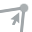
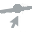

In [ ]:
from dataprep.eda import create_report
create_report(data)

### Fill Na

In [40]:
# data2 = data.dropna(axis=0)
data2 = data
data2['ph'] = data2['ph'].fillna(data2.groupby(['Potability'])['ph'].transform('mean'))
data2['Sulfate'] = data2['Sulfate'].fillna(data2.groupby(['Potability'])['Sulfate'].transform('mean'))
data2['Trihalomethanes'] = data2['Trihalomethanes'].fillna(data2.groupby(['Potability'])['Trihalomethanes'].transform('mean'))

print(data2.isna().sum())

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


In [41]:
from sklearn.model_selection import train_test_split

X = data2.drop(['Potability'], axis=1)
y = data2.Potability

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1)
train = pd.concat([train_X, train_y], axis=1)

### Sampling

In [42]:
from sklearn.utils import resample
train_potable = train[train['Potability']==1]
train_notpotable = train[train['Potability']==0]
df_minority_upsampled = resample(train_potable, replace=True, n_samples=1200)

from sklearn.utils import shuffle
train_s = pd.concat([train_notpotable, df_minority_upsampled])
train_s = shuffle(train_s)

train_s_X = train_s.drop(['Potability'], axis=1)
train_s_y =  train_s.Potability

In [ ]:
train_s

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3105,9.172625,165.687548,11319.106232,6.618853,372.554713,420.429110,13.353259,72.974051,3.686395,0
1596,8.512781,157.666918,33092.669353,6.765469,305.855570,377.618945,13.309391,43.019427,4.026622,1
2380,7.852207,169.028379,22912.189579,9.616223,332.566990,468.445396,12.601122,80.625160,3.532438,1
567,9.011589,228.919519,25208.151842,6.767010,334.564290,380.145205,15.518323,66.303555,2.897293,0
2772,8.014183,244.120098,30566.767504,7.714447,307.987458,309.930428,22.641598,61.578461,3.417076,1
...,...,...,...,...,...,...,...,...,...,...
539,7.085378,204.923829,12556.754047,5.789008,359.951766,610.767576,16.012643,52.442326,3.257744,0
1912,7.760189,206.208834,34250.163925,7.930382,299.131598,347.180780,19.350765,80.621872,4.590528,1
1475,5.514062,212.555066,27859.748306,6.646356,286.474806,524.547975,13.067803,99.918387,4.460363,0
2663,4.556657,156.422941,14400.718629,9.461285,334.564290,483.745716,7.897724,54.913943,4.392257,0


In [ ]:
from sklearn.preprocessing import StandardScaler
def scaler_samples(train_X,test_X):
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)

  return train_X, test_X

train_s_X, test_X = scaler_samples(train_s_X, test_X)

* ## RandomForestClassifier

In [43]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion='entropy', n_estimators=20)
clf.fit(train_s_X, train_s_y)

RandomForestClassifier(criterion='entropy', n_estimators=20)

In [44]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy
y_pred = clf.predict(test_X)
print("accuracy: %.2f" % accuracy(test_y, y_pred))

accuracy: 0.78


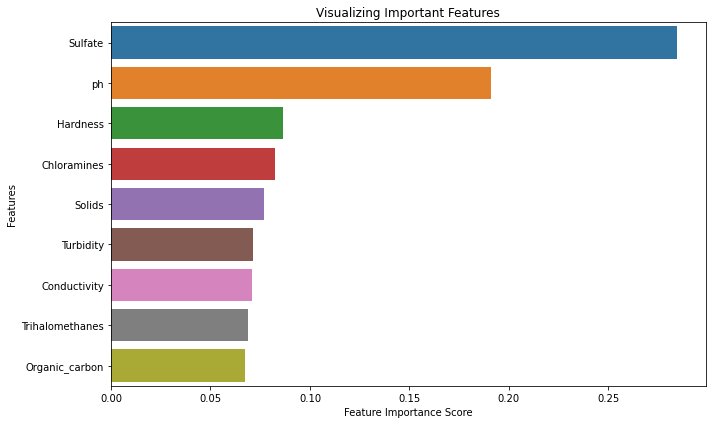

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_imp = pd.Series(clf.feature_importances_, index=X.columns.values).sort_values(ascending=False)

#print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, y_pred)

array([[181,  18],
       [ 54,  75]])

In [47]:
from sklearn.model_selection import GridSearchCV
  
# define parameter search space
param_grid = {'n_estimators': [20, 50, 100, 200, 350, 500],
              'min_samples_leaf': [2, 10, 30]}
              #'criterion': ['gini', 'entropy']} 
clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid, refit = True, cv=5, verbose = 3)
  
# fit the model for grid search
grid.fit(train_s_X, train_s_y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END min_samples_leaf=2, n_estimators=20;, score=0.858 total time=   0.2s
[CV 2/5] END min_samples_leaf=2, n_estimators=20;, score=0.838 total time=   0.1s
[CV 3/5] END min_samples_leaf=2, n_estimators=20;, score=0.843 total time=   0.1s
[CV 4/5] END min_samples_leaf=2, n_estimators=20;, score=0.867 total time=   0.1s
[CV 5/5] END min_samples_leaf=2, n_estimators=20;, score=0.856 total time=   0.1s
[CV 1/5] END min_samples_leaf=2, n_estimators=50;, score=0.873 total time=   0.3s
[CV 2/5] END min_samples_leaf=2, n_estimators=50;, score=0.862 total time=   0.3s
[CV 3/5] END min_samples_leaf=2, n_estimators=50;, score=0.867 total time=   0.4s
[CV 4/5] END min_samples_leaf=2, n_estimators=50;, score=0.875 total time=   0.4s
[CV 5/5] END min_samples_leaf=2, n_estimators=50;, score=0.861 total time=   0.3s
[CV 1/5] END min_samples_leaf=2, n_estimators=100;, score=0.873 total time=   0.7s
[CV 2/5] END min_samples_leaf=2, n_e

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [20, 50, 100, 200, 350, 500]},
             verbose=3)

In [48]:
# print best parameters after grid search
print(grid.best_params_)
  
# print how the best model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'min_samples_leaf': 2, 'n_estimators': 350}
RandomForestClassifier(min_samples_leaf=2, n_estimators=350)


In [49]:
grid_pred = grid.predict(test_X)
print("accuracy: %.2f" % accuracy(test_y, grid_pred))

accuracy: 0.81


In [37]:
from sklearn.metrics import precision_score

precision_score(test_y,grid_pred)

0.8243243243243243

## PCA

In [38]:
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

for n in range(1, 6):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(train_s)
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': train_s.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

,model,var
n,,
1,PCA(n_components=1),0.999878
2,PCA(n_components=2),0.999964
3,PCA(n_components=3),0.999983
4,PCA(n_components=4),0.999997
5,PCA(n_components=5),1.0


* ## 다른거

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
import xgboost as xgb
from scipy.stats import uniform, randint

models = [('lr', lm.LinearRegression(n_jobs=-1)),
          ('ridge', lm.Ridge()),
          ('lasso', lm.Lasso()),
          ('elastic', lm.ElasticNet()),
          ('LassoLars', lm.LassoLars()),
          ('LogisticRegression', lm.LogisticRegression()),
          ('SGDRegressor', lm.SGDRegressor()),
          ('Perceptron', lm.Perceptron(n_jobs=-1)),
          ('xgboost', xgb.XGBRegressor())]


n = 3
params = {
    'lr' : {
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    'ridge': {
        'alpha': [0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    'lasso': {
        'alpha': [0.1, 1.0, 10],
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    'elastic': {
        'alpha': [0.1, 1.0, 10],
        'normalize': [True, False],
        'fit_intercept': [True, False],
    },
    'LassoLars': {
        'alpha': [0.1, 1.0, 10],
        'normalize': [True, False],
        'fit_intercept': [True, False],
    },
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False],
    },
    'SGDRegressor': {
        'penalty': ['l1', 'l2'],
        'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False],
    },
    'Perceptron' :{
        'penalty': ['None', 'l1', 'l2'],
        'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False]
    },
    'xgboost': {
        "gamma": uniform(0, 0.5).rvs(n),
        "max_depth": range(2, 7), # default 3
        "n_estimators": randint(100, 150).rvs(n), # default 100
    }
}

best_model, best_mae = None, float('inf')
for model_name, model in models:
    param_grid = params[model_name]
    grid = GridSearchCV(model, cv=5, n_jobs=-1, param_grid=param_grid)
    grid = grid.fit(train_X, train_y)

    model = grid.best_estimator_
    predictions = model.predict(test_X)
    mae = mean_absolute_error(test_y, predictions)

    print(model_name, mae)

    if mae < best_mae:
        best_model = model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


lr 0.4849258626036556


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


ridge 0.48437766885204486


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


lasso 0.4843685861123426


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  FutureWarning,


elastic 0.4843685861123426
LassoLars 0.4843685861123426


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

LogisticRegression 0.4207920792079208
SGDRegressor 0.4843329695789114
Perceptron 0.4207920792079208
[02:05:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost 0.4272905511431175


In [ ]:
best_model

XGBRegressor(gamma=0.4614612326594042, max_depth=5, n_estimators=136)

In [ ]:
predictions = best_model.predict(test_X)
accuracy = best_model.score(test_X, test_y)
print(accuracy)

0.11943917478156652


* ## SVM

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.svm import LinearSVC, SVC
classifier = LinearSVC(C=10000, loss='hinge')
classifier.fit(train_X, train_y)
y_pred = classifier.predict(test_X)
print("accuracy on test dataset: {}".format(accuracy_score(test_y, y_pred)))

accuracy on test dataset: 0.5396039603960396


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(classifier, test_X, test_y, cv=5) 
print('cross-val-score: {}'.format(scores))
print('cross-val-score.mean: {}'.format(scores.mean()))

cross-val-score: [0.43902439 0.56097561 0.525      0.5        0.625     ]
cross-val-score.mean: 0.53


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
classifier_w_rbf = SVC(kernel = 'rbf', random_state = 0, C=1, gamma=0.01)
classifier_w_rbf.fit(train_X, train_y)
y_pred = classifier_w_rbf.predict(test_X)
print("accuracy on test dataset: {}".format(accuracy_score(test_y, y_pred)))

accuracy on test dataset: 0.594059405940594


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(classifier_w_rbf, test_X, test_y, cv=5) 
print('cross-val-score: {}'.format(scores))
print('cross-val-score.mean: {}'.format(scores.mean()))

cross-val-score: [0.58536585 0.58536585 0.575      0.575      0.575     ]
cross-val-score.mean: 0.5791463414634146


In [ ]:
from sklearn.model_selection import GridSearchCV
  
# define parameter search space
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fit the model for grid search
grid.fit(train_X, train_y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.599 total time=   0.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.599 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.599 total time=   0.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.597 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.598 total time=   0.2s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.588 total time=   5.6s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.577 total time=   4.4s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.599 total time=   4.9s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.610 total time=   4.5s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.565 total time=   3.4s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.519 total time=   0.2s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid

In [ ]:
# print best parameters after grid search
print(grid.best_params_)
  
# print how the best model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
# evaluate the model with the best parameters chosen thru tuning
grid_pred = grid.predict(test_X)
print("accuracy on test dataset: {}".format(accuracy_score(test_y, grid_pred)))
print("recall on test dataset: {}".format(recall_score(test_y, grid_pred, average='micro')))
print("precision on test dataset: {}".format(precision_score(test_y, grid_pred, average='micro')))
